In [2]:
%pip install tensorflow 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

file_path = r'C:\Users\KIIT\Desktop\ibm\ramen-ratings.csv'
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nFirst few rows:")
df.head()


  Using cached absl_py-2.3.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-1.17.2-cp311-cp311-win_amd64.whl.metadata (6.5 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached h5py-3.14.0-cp311-cp311-win_amd64.whl.metadata (2.7 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp311-cp311-win_amd64.whl.metadata (14 kB)
  Using cached charset_normalizer-3.4.2-cp311-cp311-win_amd64.whl.metadata (36 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB

  You can safely remove it manually.
  You can safely remove it manually.


Dataset Shape: (2580, 7)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB

First few rows:


,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN


Dataset Statistics:
          Review #
count  2580.000000
mean   1290.500000
std     744.926171
min       1.000000
25%     645.750000
50%    1290.500000
75%    1935.250000
max    2580.000000

Missing Values:
Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64

Unique values per column:
Review #: 2580
Brand: 355
Variety: 2413
Style: 7
Country: 38
Stars: 51
Top Ten: 38


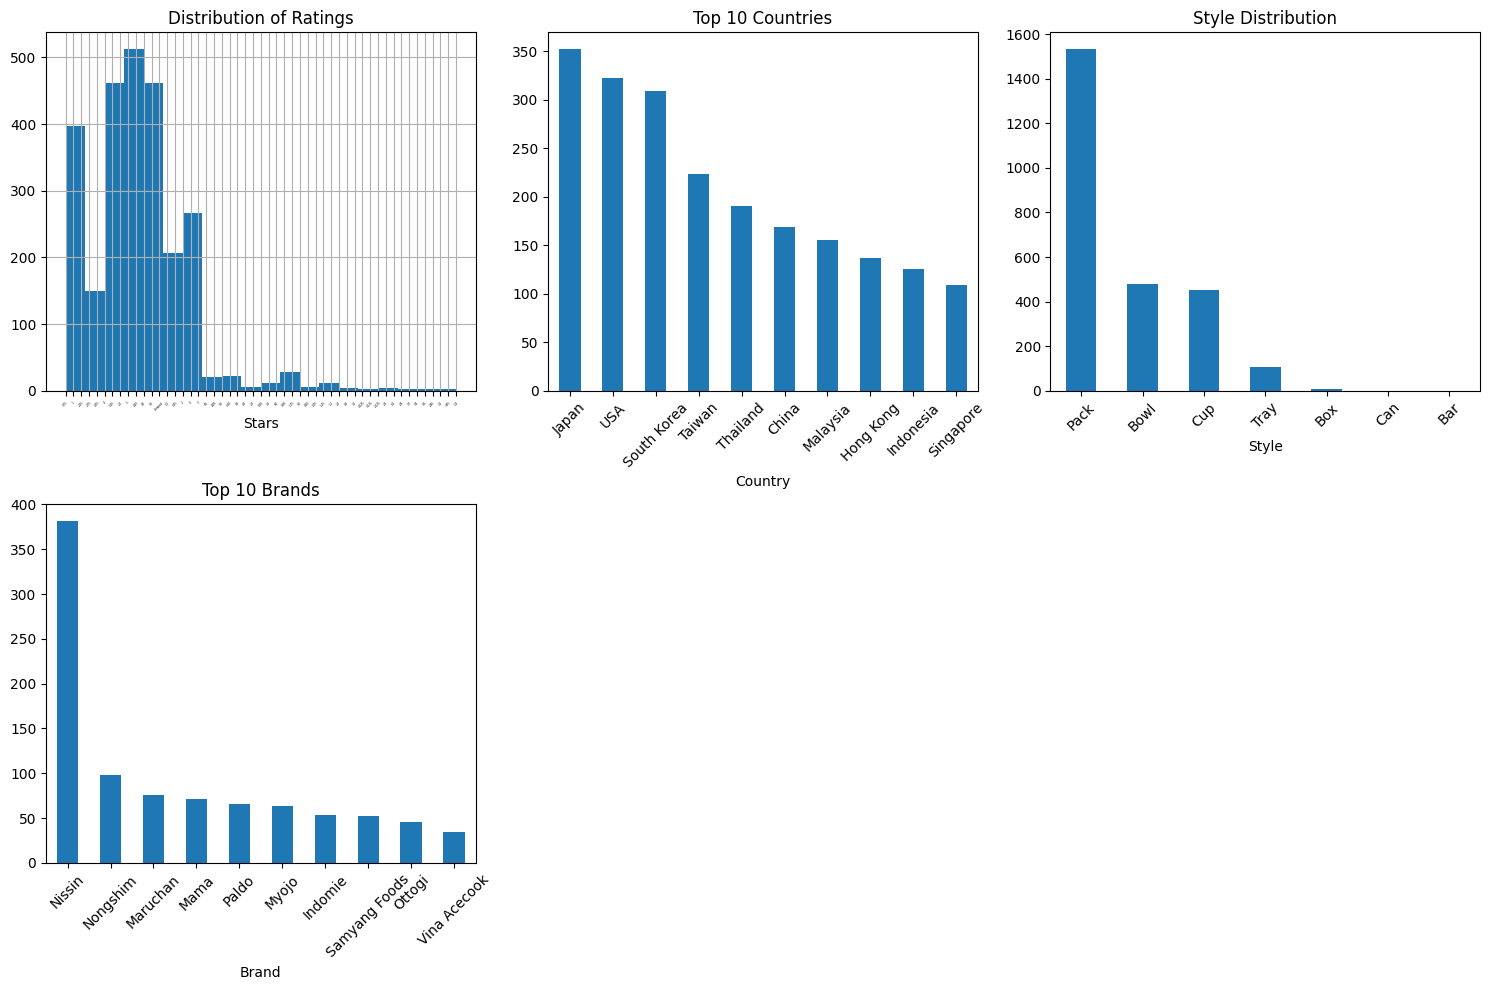

In [16]:
print("Dataset Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nUnique values per column:")
for col in df.columns:
    print(f"{col}: {df[col].nunique()}")

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
df['Stars'].hist(bins=20)
plt.title('Distribution of Ratings')
plt.xlabel('Stars')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.tick_params(axis='x', labelsize=2)  # Make labels smaller

plt.subplot(2, 3, 2)
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries')
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
df['Style'].value_counts().plot(kind='bar')
plt.title('Style Distribution')
plt.xticks(rotation=45)  # Add rotation for style labels too

plt.subplot(2, 3, 4)
df['Brand'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Brands')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [5]:
df_clean = df.dropna(subset=['Stars'])

# Convert Stars to numeric, replacing non-numeric values with NaN
df_clean['Stars'] = pd.to_numeric(df_clean['Stars'], errors='coerce')

# Drop rows where Stars couldn't be converted to numeric
df_clean = df_clean.dropna(subset=['Stars'])

le_brand = LabelEncoder()
le_country = LabelEncoder()
le_style = LabelEncoder()

df_clean['Brand_encoded'] = le_brand.fit_transform(df_clean['Brand'])
df_clean['Country_encoded'] = le_country.fit_transform(df_clean['Country'])
df_clean['Style_encoded'] = le_style.fit_transform(df_clean['Style'])

df_clean['Variety_length'] = df_clean['Variety'].str.len()
df_clean['Brand_popularity'] = df_clean.groupby('Brand')['Brand'].transform('count')
df_clean['Country_avg_rating'] = df_clean.groupby('Country')['Stars'].transform('mean')

df_clean['Rating_category'] = pd.cut(df_clean['Stars'], 
                                   bins=[0, 2.5, 3.5, 5], 
                                   labels=['Low', 'Medium', 'High'])

df_clean['Top_Ten_binary'] = df_clean['Top Ten'].notna().astype(int)

print("Processed dataset shape:", df_clean.shape)
print("Rating categories distribution:")
print(df_clean['Rating_category'].value_counts())

Processed dataset shape: (2577, 15)
Rating categories distribution:
Rating_category
High      1483
Medium     777
Low        291
Name: count, dtype: int64


In [7]:
features = ['Brand_encoded', 'Country_encoded', 'Style_encoded', 
           'Variety_length', 'Brand_popularity', 'Country_avg_rating']
X = df_clean[features]
y = df_clean['Rating_category']

# Remove any NaN values from the target variable
mask = y.notna()
X = X[mask]
y = y[mask]

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

# Verify the range of encoded labels
print(f"Unique encoded labels: {np.unique(y_encoded)}")
print(f"Number of classes: {len(le_target.classes_)}")
print(f"Class labels: {le_target.classes_}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, 
                                                    test_size=0.2, random_state=42, 
                                                    stratify=y_encoded)

model1 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(len(le_target.classes_), activation='softmax')  # Use actual number of classes
])

model1.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

history1 = model1.fit(X_train, y_train,
                     epochs=100,
                     batch_size=32,
                     validation_split=0.2,
                     callbacks=[early_stopping, reduce_lr],
                     verbose=1)

y_pred1 = model1.predict(X_test)
y_pred1_classes = np.argmax(y_pred1, axis=1)

print("Model 1 - Multi-Class Classification Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred1_classes):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred1_classes, 
                          target_names=le_target.classes_))

Unique encoded labels: [0 1 2]
Number of classes: 3
Class labels: ['High' 'Low' 'Medium']
Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4742 - loss: 1.0344 - val_accuracy: 0.6324 - val_loss: 0.8417 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5846 - loss: 0.9158 - val_accuracy: 0.6324 - val_loss: 0.8153 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5753 - loss: 0.9081 - val_accuracy: 0.6348 - val_loss: 0.8207 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5848 - loss: 0.8894 - val_accuracy: 0.6324 - val_loss: 0.8193 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5956 - loss: 0.8738 - val_accuracy: 0.6520 - val_loss: 0.8206 - learning_rate: 0.0010
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5796 - loss: 0.8862 - val_accuracy: 0.6324 - val_loss: 0.8116 - learning_rate: 0.0010
Epoc

In [8]:
X_reg = df_clean[features]
y_reg = df_clean['Stars']

X_reg_scaled = scaler.fit_transform(X_reg)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg_scaled, y_reg, test_size=0.2, random_state=42)

model2 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_reg.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae'])

history2 = model2.fit(X_train_reg, y_train_reg,
                     epochs=100,
                     batch_size=32,
                     validation_split=0.2,
                     callbacks=[early_stopping, reduce_lr],
                     verbose=1)

y_pred2 = model2.predict(X_test_reg)
mse = np.mean((y_test_reg - y_pred2.flatten())**2)
mae = np.mean(np.abs(y_test_reg - y_pred2.flatten()))

print("Model 2 - Regression Results:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")


Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.9716 - mae: 2.4399 - val_loss: 1.3267 - val_mae: 0.9229 - learning_rate: 0.0010
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6536 - mae: 1.0030 - val_loss: 1.0994 - val_mae: 0.8159 - learning_rate: 0.0010
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5734 - mae: 0.9880 - val_loss: 1.2124 - val_mae: 0.9037 - learning_rate: 0.0010
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3799 - mae: 0.8968 - val_loss: 1.1342 - val_mae: 0.8553 - learning_rate: 0.0010
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3354 - mae: 0.8901 - val_loss: 1.0368 - val_mae: 0.8072 - learning_rate: 0.0010
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2376 - mae: 0.8773 - val_loss: 1.2017 - val_mae: 0.9035 - learning_rate: 0.0010
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1988 - mae: 0.8576 - val_loss: 1.2541 - val_mae: 0.9337 - learning_rate: 0.0010
Epoch 8/100
5

In [9]:
features_ae = ['Brand_encoded', 'Country_encoded', 'Style_encoded', 
               'Variety_length', 'Brand_popularity', 'Country_avg_rating', 'Stars']
X_ae = df_clean[features_ae]
X_ae_scaled = StandardScaler().fit_transform(X_ae)

input_dim = X_ae_scaled.shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim,))
encoder = Dense(32, activation="relu")(input_layer)
encoder = Dense(16, activation="relu")(encoder)
encoder = Dense(encoding_dim, activation="relu")(encoder)

decoder = Dense(16, activation="relu")(encoder)
decoder = Dense(32, activation="relu")(decoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

history3 = autoencoder.fit(X_ae_scaled, X_ae_scaled,
                          epochs=100,
                          batch_size=32,
                          validation_split=0.2,
                          callbacks=[early_stopping],
                          verbose=1)

X_ae_pred = autoencoder.predict(X_ae_scaled)
mse_ae = np.mean(np.power(X_ae_scaled - X_ae_pred, 2), axis=1)
threshold = np.percentile(mse_ae, 95)
anomalies = mse_ae > threshold

print("Model 3 - Autoencoder Results:")
print(f"Reconstruction threshold: {threshold:.4f}")
print(f"Number of anomalies detected: {np.sum(anomalies)}")
print(f"Percentage of anomalies: {np.sum(anomalies)/len(mse_ae)*100:.2f}%")


Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2349 - val_loss: 1.0227
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0299 - val_loss: 0.8442
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8910 - val_loss: 0.8003
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8592 - val_loss: 0.7580
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8266 - val_loss: 0.7281
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7697 - val_loss: 0.7124
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7516 - val_loss: 0.7071
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7510 - val_loss: 0.6975
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7339 - val_loss: 0.6942
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7306 - val_loss: 0.6923
Epoch 11/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7465 - val_loss: 0.6878
Epoch 12/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7

Reinforcement Learning - Q-Learning Results:
Average reward over last 100 episodes: 9.2686
Best episode reward: 51.5841


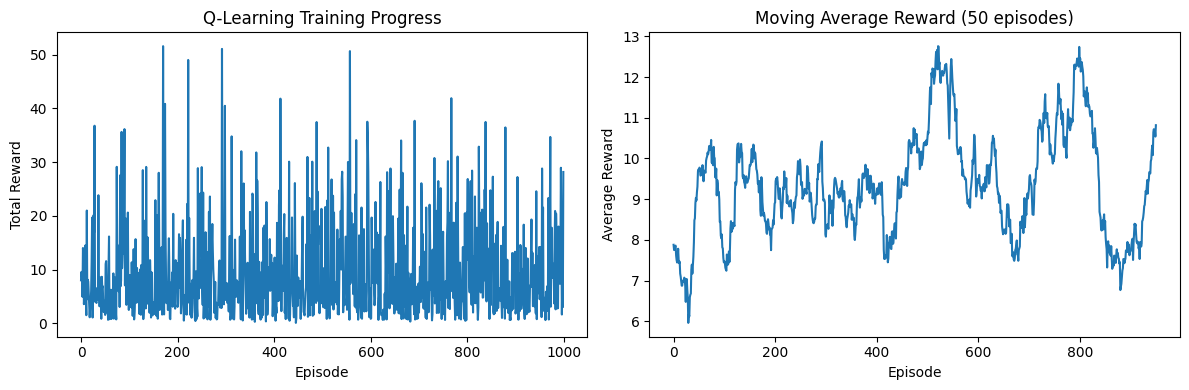

In [10]:
class RamenRecommendationEnv:
    def __init__(self, df):
        self.df = df
        self.countries = df['Country'].unique()
        self.styles = df['Style'].unique()
        self.n_countries = len(self.countries)
        self.n_styles = len(self.styles)
        self.state_space = self.n_countries * self.n_styles
        self.action_space = len(df)
        self.current_state = 0
        self.user_preferences = np.random.rand(3)
        
    def reset(self):
        self.current_state = np.random.randint(0, self.state_space)
        return self.current_state
    
    def step(self, action):
        ramen = self.df.iloc[action]
        country_idx = np.where(self.countries == ramen['Country'])[0][0]
        style_idx = np.where(self.styles == ramen['Style'])[0][0]
        
        reward = ramen['Stars'] / 5.0
        
        if ramen['Top Ten'] is not np.nan:
            reward += 0.5
            
        reward += np.random.normal(0, 0.1)
        
        next_state = country_idx * self.n_styles + style_idx
        done = np.random.random() < 0.1
        
        self.current_state = next_state
        return next_state, reward, done

env = RamenRecommendationEnv(df_clean)

n_states = env.state_space
n_actions = min(1000, env.action_space)
q_table = np.zeros((n_states, n_actions))

alpha = 0.1
gamma = 0.95
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
episodes = 1000

rewards_per_episode = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    
    for step in range(100):
        if np.random.random() < epsilon:
            action = np.random.randint(0, n_actions)
        else:
            action = np.argmax(q_table[state])
        
        next_state, reward, done = env.step(action)
        
        q_table[state, action] = q_table[state, action] + alpha * (
            reward + gamma * np.max(q_table[next_state]) - q_table[state, action])
        
        state = next_state
        total_reward += reward
        
        if done:
            break
    
    rewards_per_episode.append(total_reward)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

print("Reinforcement Learning - Q-Learning Results:")
print(f"Average reward over last 100 episodes: {np.mean(rewards_per_episode[-100:]):.4f}")
print(f"Best episode reward: {np.max(rewards_per_episode):.4f}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rewards_per_episode)
plt.title('Q-Learning Training Progress')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(np.convolve(rewards_per_episode, np.ones(50)/50, mode='valid'))
plt.title('Moving Average Reward (50 episodes)')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.tight_layout()
plt.show()


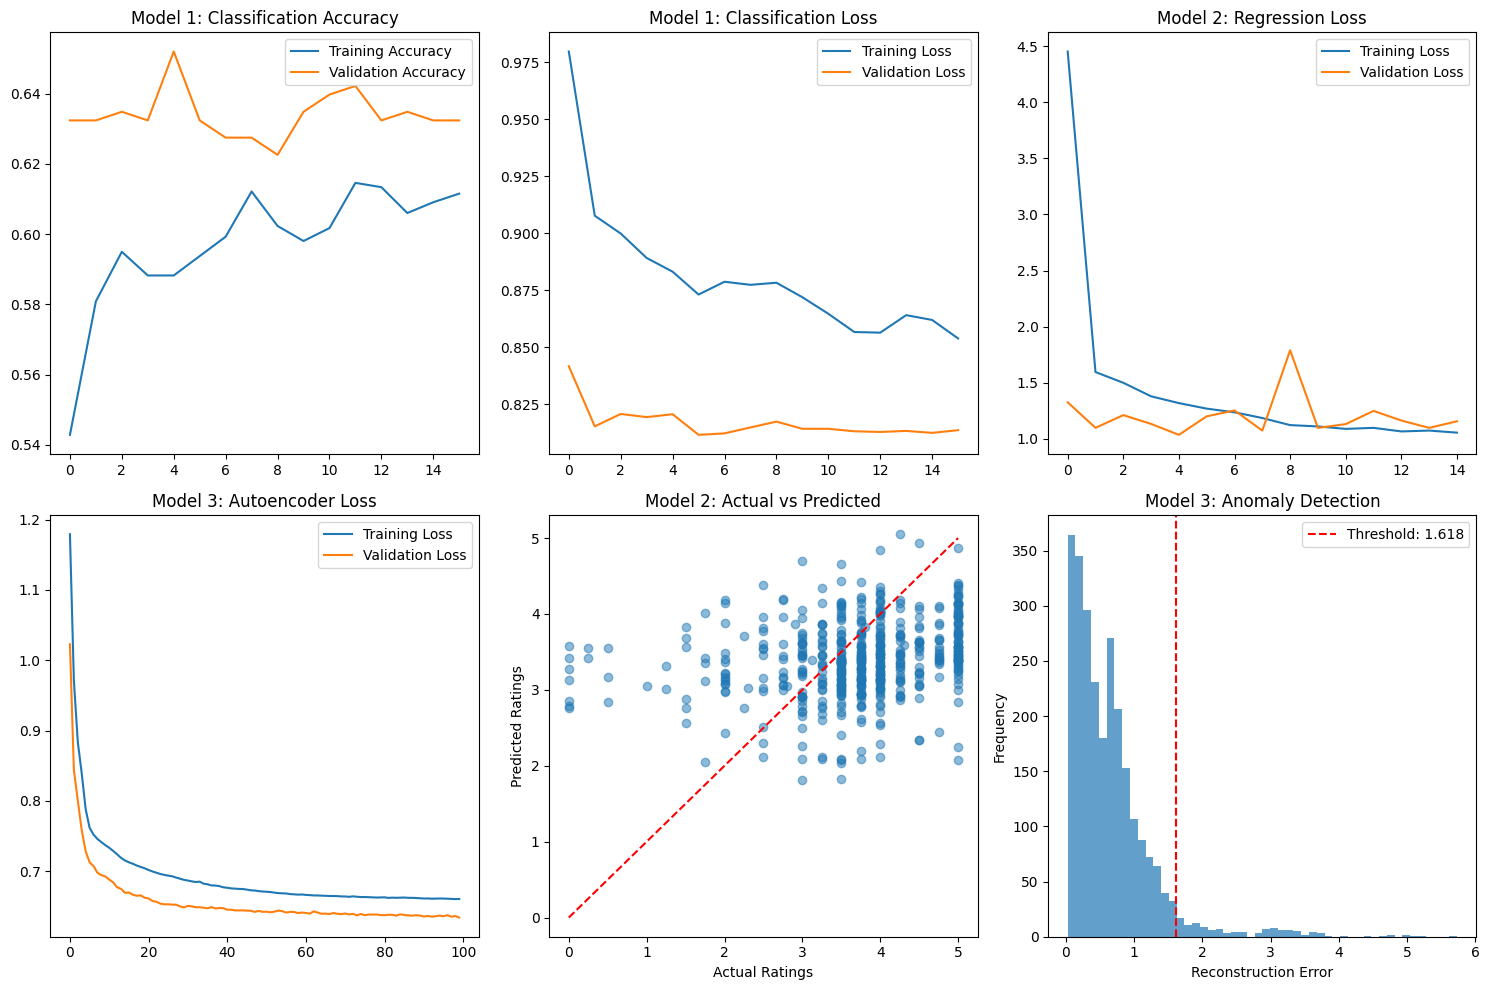

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model 1: Classification Accuracy')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Model 1: Classification Loss')
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model 2: Regression Loss')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.title('Model 3: Autoencoder Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.scatter(y_test_reg, y_pred2, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Model 2: Actual vs Predicted')

plt.subplot(2, 3, 6)
plt.hist(mse_ae, bins=50, alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.3f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Model 3: Anomaly Detection')
plt.legend()

plt.tight_layout()
plt.show()


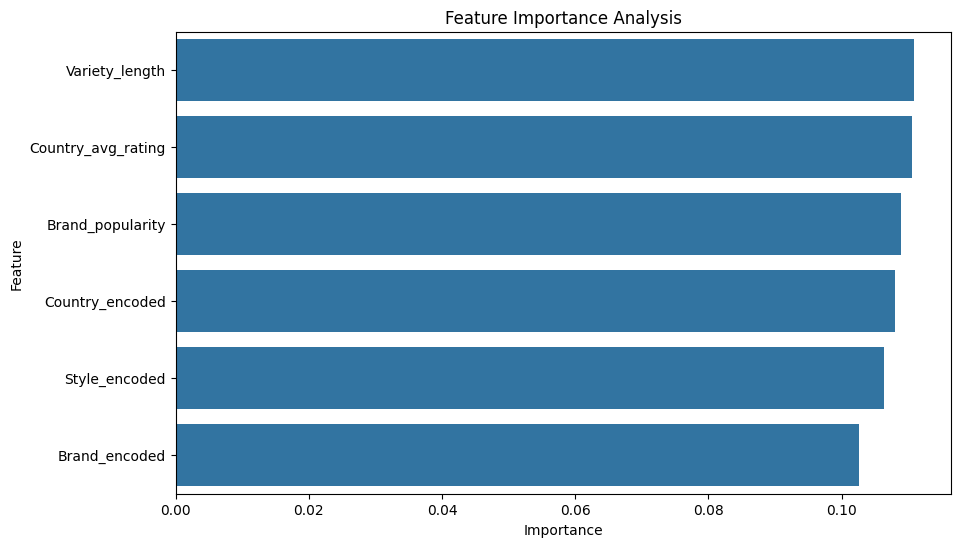

Feature Importance Ranking:
              Feature  Importance
3      Variety_length    0.110850
5  Country_avg_rating    0.110660
4    Brand_popularity    0.108878
1     Country_encoded    0.108066
2       Style_encoded    0.106370
0       Brand_encoded    0.102601


In [12]:
feature_importance_analysis = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(model1.layers[0].get_weights()[0]).mean(axis=1)
})
feature_importance_analysis = feature_importance_analysis.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_analysis, x='Importance', y='Feature')
plt.title('Feature Importance Analysis')
plt.show()

print("Feature Importance Ranking:")
print(feature_importance_analysis)


In [13]:
models_comparison = pd.DataFrame({
    'Model': ['Classification NN', 'Regression NN', 'Autoencoder', 'Q-Learning'],
    'Primary_Metric': [f'{accuracy_score(y_test, y_pred1_classes):.4f} (Accuracy)', 
                      f'{mae:.4f} (MAE)', 
                      f'{np.sum(anomalies)} (Anomalies)', 
                      f'{np.mean(rewards_per_episode[-100:]):.4f} (Avg Reward)'],
    'Use_Case': ['Rating Prediction', 'Exact Rating Prediction', 'Quality Control', 'Recommendation System'],
    'Complexity': ['Medium', 'Medium', 'High', 'High']
})

print("Model Comparison Summary:")
print(models_comparison.to_string(index=False))


Model Comparison Summary:
            Model      Primary_Metric                Use_Case Complexity
Classification NN   0.5910 (Accuracy)       Rating Prediction     Medium
    Regression NN        0.8311 (MAE) Exact Rating Prediction     Medium
      Autoencoder     129 (Anomalies)         Quality Control       High
       Q-Learning 9.2686 (Avg Reward)   Recommendation System       High


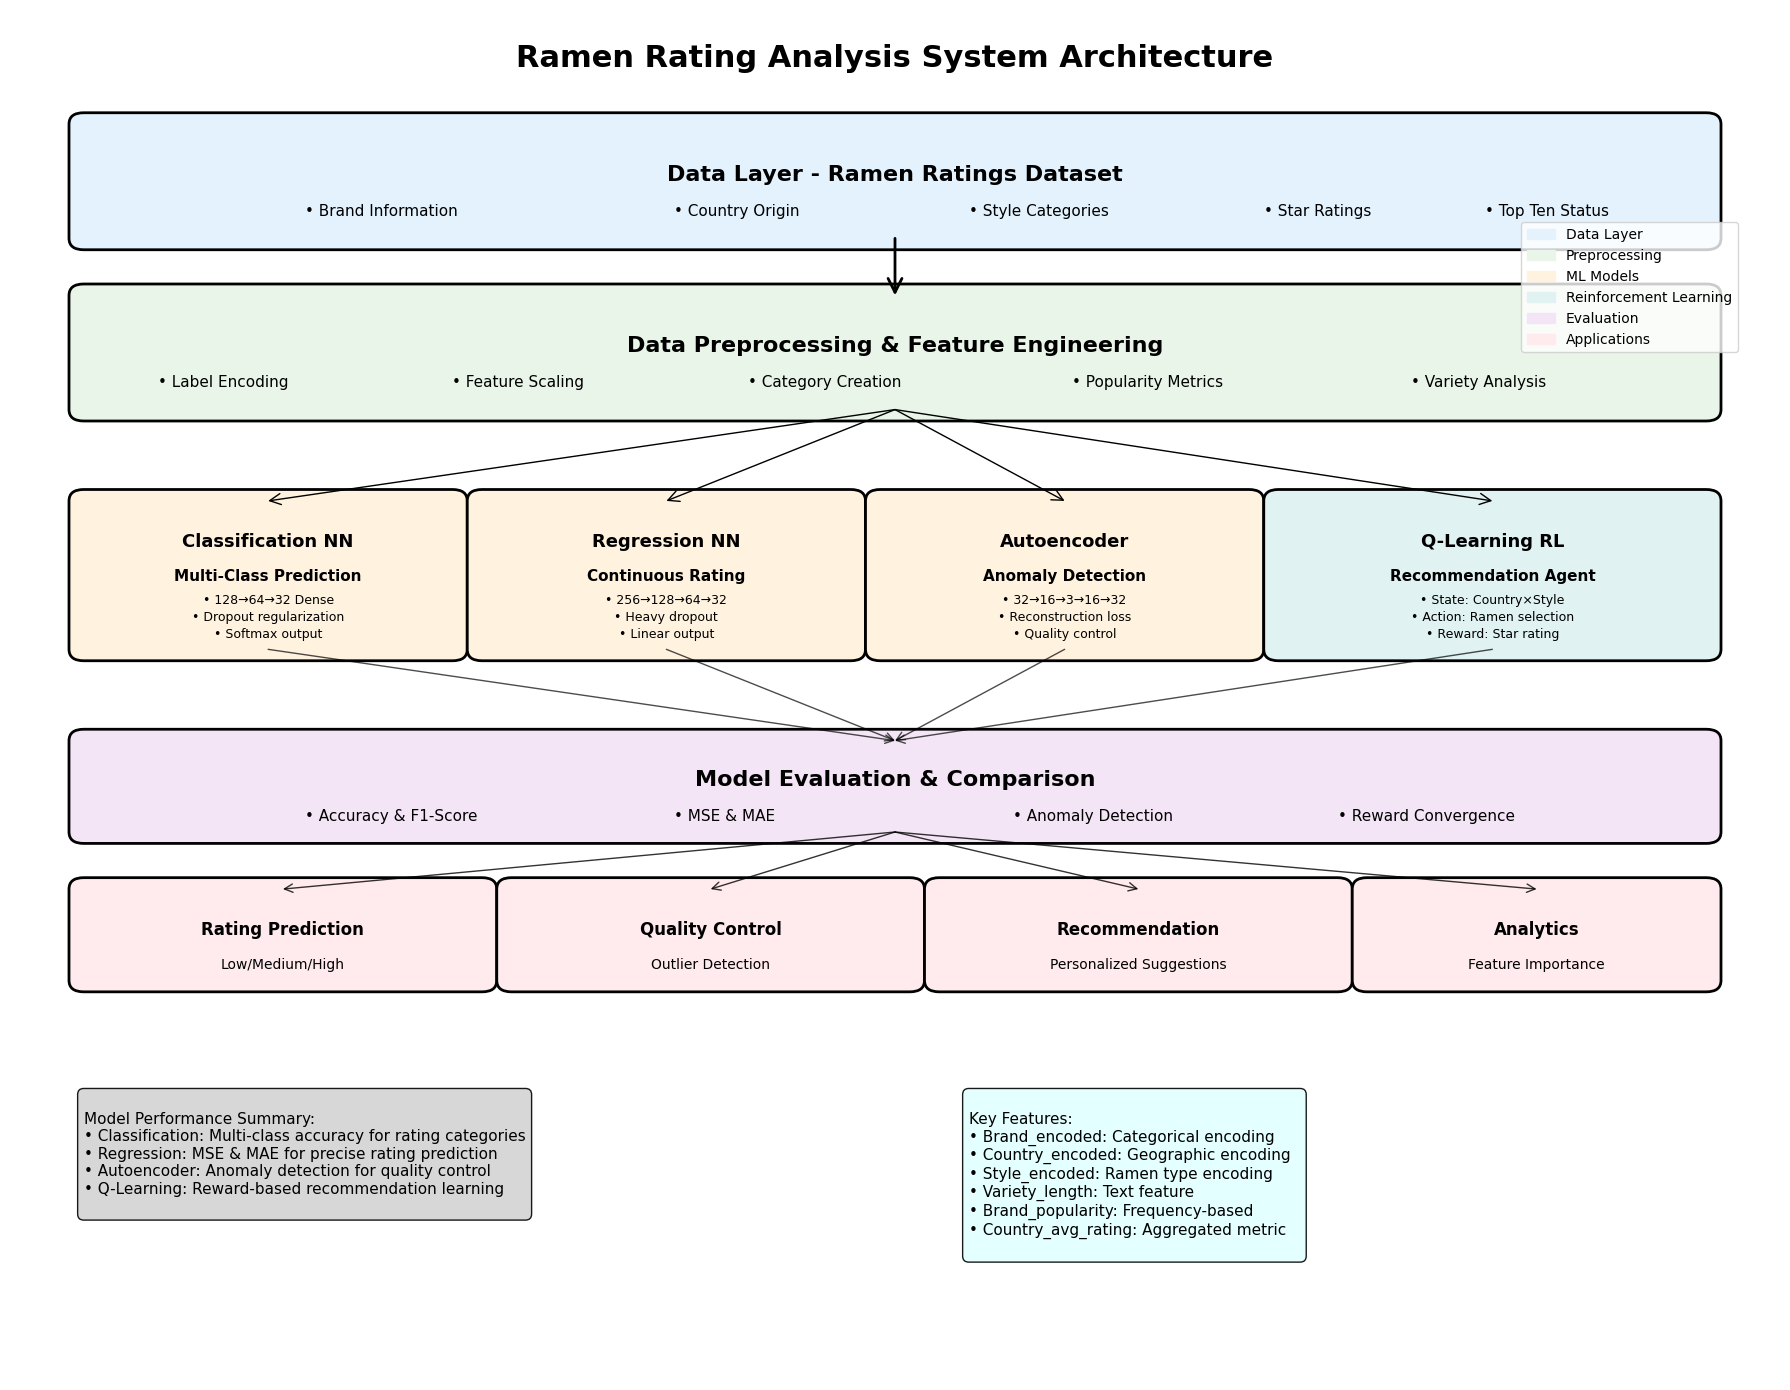

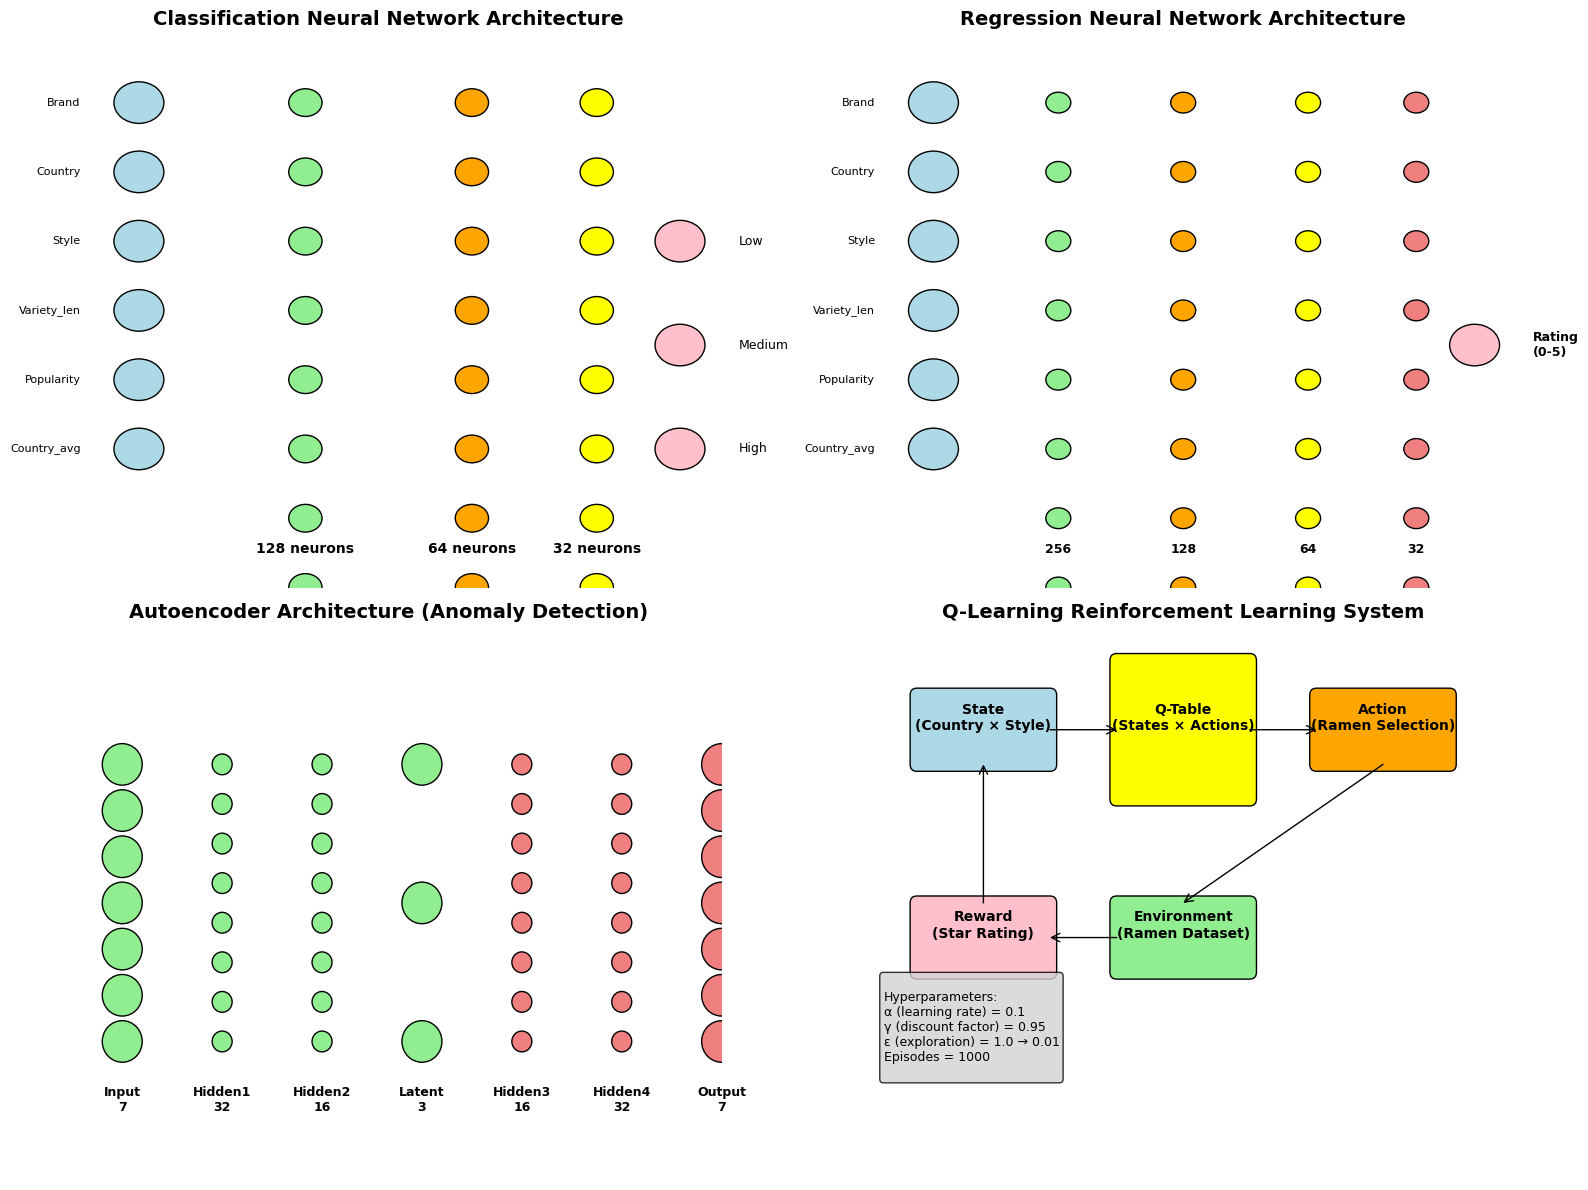

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyBboxPatch, ConnectionPatch, Circle
import numpy as np

# Create the comprehensive system architecture diagram
fig, ax = plt.subplots(figsize=(18, 14))
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.axis('off')

# Define colors for different components
colors = {
    'data': '#E3F2FD',           # Light blue
    'preprocessing': '#E8F5E8',   # Light green
    'models': '#FFF3E0',         # Light orange
    'evaluation': '#F3E5F5',     # Light purple
    'output': '#FFEBEE',         # Light pink
    'rl': '#E0F2F1'              # Light teal
}

# Title
ax.text(6, 11.5, 'Ramen Rating Analysis System Architecture', 
        fontsize=22, fontweight='bold', ha='center')

# Data Layer
data_box = FancyBboxPatch((0.5, 10), 11, 1, 
                         boxstyle="round,pad=0.1", 
                         facecolor=colors['data'], 
                         edgecolor='black', linewidth=2)
ax.add_patch(data_box)
ax.text(6, 10.5, 'Data Layer - Ramen Ratings Dataset', fontsize=16, fontweight='bold', ha='center')
ax.text(2, 10.2, '• Brand Information', fontsize=11, ha='left')
ax.text(4.5, 10.2, '• Country Origin', fontsize=11, ha='left')
ax.text(6.5, 10.2, '• Style Categories', fontsize=11, ha='left')
ax.text(8.5, 10.2, '• Star Ratings', fontsize=11, ha='left')
ax.text(10, 10.2, '• Top Ten Status', fontsize=11, ha='left')

# Preprocessing Layer
prep_box = FancyBboxPatch((0.5, 8.5), 11, 1, 
                         boxstyle="round,pad=0.1", 
                         facecolor=colors['preprocessing'], 
                         edgecolor='black', linewidth=2)
ax.add_patch(prep_box)
ax.text(6, 9, 'Data Preprocessing & Feature Engineering', fontsize=16, fontweight='bold', ha='center')
ax.text(1, 8.7, '• Label Encoding', fontsize=11, ha='left')
ax.text(3, 8.7, '• Feature Scaling', fontsize=11, ha='left')
ax.text(5, 8.7, '• Category Creation', fontsize=11, ha='left')
ax.text(7.2, 8.7, '• Popularity Metrics', fontsize=11, ha='left')
ax.text(9.5, 8.7, '• Variety Analysis', fontsize=11, ha='left')

# Model Components - Four main models
model_y = 7
model_height = 1.3

# Classification Model
class_box = FancyBboxPatch((0.5, model_y-0.6), 2.5, model_height, 
                          boxstyle="round,pad=0.1", 
                          facecolor=colors['models'], 
                          edgecolor='black', linewidth=2)
ax.add_patch(class_box)
ax.text(1.75, model_y+0.3, 'Classification NN', fontsize=13, fontweight='bold', ha='center')
ax.text(1.75, model_y, 'Multi-Class Prediction', fontsize=11, fontweight='bold', ha='center')
ax.text(1.75, model_y-0.2, '• 128→64→32 Dense', fontsize=9, ha='center')
ax.text(1.75, model_y-0.35, '• Dropout regularization', fontsize=9, ha='center')
ax.text(1.75, model_y-0.5, '• Softmax output', fontsize=9, ha='center')

# Regression Model
reg_box = FancyBboxPatch((3.2, model_y-0.6), 2.5, model_height, 
                        boxstyle="round,pad=0.1", 
                        facecolor=colors['models'], 
                        edgecolor='black', linewidth=2)
ax.add_patch(reg_box)
ax.text(4.45, model_y+0.3, 'Regression NN', fontsize=13, fontweight='bold', ha='center')
ax.text(4.45, model_y, 'Continuous Rating', fontsize=11, fontweight='bold', ha='center')
ax.text(4.45, model_y-0.2, '• 256→128→64→32', fontsize=9, ha='center')
ax.text(4.45, model_y-0.35, '• Heavy dropout', fontsize=9, ha='center')
ax.text(4.45, model_y-0.5, '• Linear output', fontsize=9, ha='center')

# Autoencoder Model
ae_box = FancyBboxPatch((5.9, model_y-0.6), 2.5, model_height, 
                       boxstyle="round,pad=0.1", 
                       facecolor=colors['models'], 
                       edgecolor='black', linewidth=2)
ax.add_patch(ae_box)
ax.text(7.15, model_y+0.3, 'Autoencoder', fontsize=13, fontweight='bold', ha='center')
ax.text(7.15, model_y, 'Anomaly Detection', fontsize=11, fontweight='bold', ha='center')
ax.text(7.15, model_y-0.2, '• 32→16→3→16→32', fontsize=9, ha='center')
ax.text(7.15, model_y-0.35, '• Reconstruction loss', fontsize=9, ha='center')
ax.text(7.15, model_y-0.5, '• Quality control', fontsize=9, ha='center')

# Q-Learning Model
rl_box = FancyBboxPatch((8.6, model_y-0.6), 2.9, model_height, 
                       boxstyle="round,pad=0.1", 
                       facecolor=colors['rl'], 
                       edgecolor='black', linewidth=2)
ax.add_patch(rl_box)
ax.text(10.05, model_y+0.3, 'Q-Learning RL', fontsize=13, fontweight='bold', ha='center')
ax.text(10.05, model_y, 'Recommendation Agent', fontsize=11, fontweight='bold', ha='center')
ax.text(10.05, model_y-0.2, '• State: Country×Style', fontsize=9, ha='center')
ax.text(10.05, model_y-0.35, '• Action: Ramen selection', fontsize=9, ha='center')
ax.text(10.05, model_y-0.5, '• Reward: Star rating', fontsize=9, ha='center')

# Evaluation Layer
eval_box = FancyBboxPatch((0.5, 4.8), 11, 0.8, 
                         boxstyle="round,pad=0.1", 
                         facecolor=colors['evaluation'], 
                         edgecolor='black', linewidth=2)
ax.add_patch(eval_box)
ax.text(6, 5.2, 'Model Evaluation & Comparison', fontsize=16, fontweight='bold', ha='center')
ax.text(2, 4.9, '• Accuracy & F1-Score', fontsize=11, ha='left')
ax.text(4.5, 4.9, '• MSE & MAE', fontsize=11, ha='left')
ax.text(6.8, 4.9, '• Anomaly Detection', fontsize=11, ha='left')
ax.text(9, 4.9, '• Reward Convergence', fontsize=11, ha='left')

# Output Applications
output_y = 3.5
app_height = 0.8

# Rating Prediction
pred_box = FancyBboxPatch((0.5, output_y), 2.7, app_height, 
                         boxstyle="round,pad=0.1", 
                         facecolor=colors['output'], 
                         edgecolor='black', linewidth=2)
ax.add_patch(pred_box)
ax.text(1.85, output_y+0.4, 'Rating Prediction', fontsize=12, fontweight='bold', ha='center')
ax.text(1.85, output_y+0.1, 'Low/Medium/High', fontsize=10, ha='center')

# Quality Control
quality_box = FancyBboxPatch((3.4, output_y), 2.7, app_height, 
                            boxstyle="round,pad=0.1", 
                            facecolor=colors['output'], 
                            edgecolor='black', linewidth=2)
ax.add_patch(quality_box)
ax.text(4.75, output_y+0.4, 'Quality Control', fontsize=12, fontweight='bold', ha='center')
ax.text(4.75, output_y+0.1, 'Outlier Detection', fontsize=10, ha='center')

# Recommendation System
rec_box = FancyBboxPatch((6.3, output_y), 2.7, app_height, 
                        boxstyle="round,pad=0.1", 
                        facecolor=colors['output'], 
                        edgecolor='black', linewidth=2)
ax.add_patch(rec_box)
ax.text(7.65, output_y+0.4, 'Recommendation', fontsize=12, fontweight='bold', ha='center')
ax.text(7.65, output_y+0.1, 'Personalized Suggestions', fontsize=10, ha='center')

# Insights & Analytics
insights_box = FancyBboxPatch((9.2, output_y), 2.3, app_height, 
                             boxstyle="round,pad=0.1", 
                             facecolor=colors['output'], 
                             edgecolor='black', linewidth=2)
ax.add_patch(insights_box)
ax.text(10.35, output_y+0.4, 'Analytics', fontsize=12, fontweight='bold', ha='center')
ax.text(10.35, output_y+0.1, 'Feature Importance', fontsize=10, ha='center')

# Add flow arrows
# Data to Preprocessing
arrow1 = ConnectionPatch((6, 10), (6, 9.5), "data", "data", 
                        arrowstyle="->", shrinkA=0, shrinkB=0, 
                        mutation_scale=25, fc="black", linewidth=2)
ax.add_patch(arrow1)

# Preprocessing to Models
model_centers = [1.75, 4.45, 7.15, 10.05]
for center in model_centers:
    arrow = ConnectionPatch((6, 8.5), (center, model_y+0.7), "data", "data", 
                           arrowstyle="->", shrinkA=0, shrinkB=0, 
                           mutation_scale=20, fc="black")
    ax.add_patch(arrow)

# Models to Evaluation
for center in model_centers:
    arrow = ConnectionPatch((center, model_y-0.6), (6, 5.6), "data", "data", 
                           arrowstyle="->", shrinkA=0, shrinkB=0, 
                           mutation_scale=15, fc="gray", alpha=0.7)
    ax.add_patch(arrow)

# Evaluation to Applications
app_centers = [1.85, 4.75, 7.65, 10.35]
for i, center in enumerate(app_centers):
    arrow = ConnectionPatch((6, 4.8), (center, output_y+0.8), "data", "data", 
                           arrowstyle="->", shrinkA=0, shrinkB=0, 
                           mutation_scale=15, fc="darkblue", alpha=0.8)
    ax.add_patch(arrow)

# Add performance metrics
metrics_text = """
Model Performance Summary:
• Classification: Multi-class accuracy for rating categories
• Regression: MSE & MAE for precise rating prediction  
• Autoencoder: Anomaly detection for quality control
• Q-Learning: Reward-based recommendation learning
"""

ax.text(0.5, 2.5, metrics_text, fontsize=11, 
        bbox=dict(boxstyle="round,pad=0.4", facecolor='lightgray', alpha=0.9),
        verticalalignment='top')

# Add feature engineering details
features_text = """
Key Features:
• Brand_encoded: Categorical encoding
• Country_encoded: Geographic encoding  
• Style_encoded: Ramen type encoding
• Variety_length: Text feature
• Brand_popularity: Frequency-based
• Country_avg_rating: Aggregated metric
"""

ax.text(6.5, 2.5, features_text, fontsize=11, 
        bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcyan', alpha=0.9),
        verticalalignment='top')

# Add legend
legend_elements = [
    patches.Patch(color=colors['data'], label='Data Layer'),
    patches.Patch(color=colors['preprocessing'], label='Preprocessing'),
    patches.Patch(color=colors['models'], label='ML Models'),
    patches.Patch(color=colors['rl'], label='Reinforcement Learning'),
    patches.Patch(color=colors['evaluation'], label='Evaluation'),
    patches.Patch(color=colors['output'], label='Applications')
]

ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.85), fontsize=10)

plt.tight_layout()
plt.show()

# Create detailed neural network architectures
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Classification Neural Network Detail
ax1.set_xlim(0, 8)
ax1.set_ylim(0, 8)
ax1.axis('off')
ax1.set_title('Classification Neural Network Architecture', fontsize=14, fontweight='bold')

# Input layer
input_neurons = ['Brand', 'Country', 'Style', 'Variety_len', 'Popularity', 'Country_avg']
for i, neuron in enumerate(input_neurons):
    circle = Circle((1, 7-i), 0.3, facecolor='lightblue', edgecolor='black')
    ax1.add_patch(circle)
    ax1.text(0.3, 7-i, neuron, fontsize=8, ha='right', va='center')

# Hidden layers
hidden_configs = [(3, 128, 'lightgreen'), (5, 64, 'orange'), (6.5, 32, 'yellow')]
for x, neurons, color in hidden_configs:
    for i in range(min(neurons, 8)):  # Show max 8 neurons for visualization
        y_pos = 7 - i * 7/(min(neurons, 8)-1) if neurons > 1 else 3.5
        circle = Circle((x, y_pos), 0.2, facecolor=color, edgecolor='black')
        ax1.add_patch(circle)
    ax1.text(x, 0.5, f'{neurons} neurons', fontsize=10, ha='center', fontweight='bold')

# Output layer
output_classes = ['Low', 'Medium', 'High']
for i, class_name in enumerate(output_classes):
    circle = Circle((7.5, 5-i*1.5), 0.3, facecolor='pink', edgecolor='black')
    ax1.add_patch(circle)
    ax1.text(8.2, 5-i*1.5, class_name, fontsize=9, ha='left', va='center')

# Regression Neural Network Detail
ax2.set_xlim(0, 8)
ax2.set_ylim(0, 8)
ax2.axis('off')
ax2.set_title('Regression Neural Network Architecture', fontsize=14, fontweight='bold')

# Similar input layer
for i, neuron in enumerate(input_neurons):
    circle = Circle((1, 7-i), 0.3, facecolor='lightblue', edgecolor='black')
    ax2.add_patch(circle)
    ax2.text(0.3, 7-i, neuron, fontsize=8, ha='right', va='center')

# Deeper hidden layers for regression
reg_configs = [(2.5, 256, 'lightgreen'), (4, 128, 'orange'), (5.5, 64, 'yellow'), (6.8, 32, 'lightcoral')]
for x, neurons, color in reg_configs:
    for i in range(min(neurons, 8)):
        y_pos = 7 - i * 7/(min(neurons, 8)-1) if neurons > 1 else 3.5
        circle = Circle((x, y_pos), 0.15, facecolor=color, edgecolor='black')
        ax2.add_patch(circle)
    ax2.text(x, 0.5, f'{neurons}', fontsize=9, ha='center', fontweight='bold')

# Single output for rating
circle = Circle((7.5, 3.5), 0.3, facecolor='pink', edgecolor='black')
ax2.add_patch(circle)
ax2.text(8.2, 3.5, 'Rating\n(0-5)', fontsize=9, ha='left', va='center', fontweight='bold')

# Autoencoder Architecture
ax3.set_xlim(0, 10)
ax3.set_ylim(0, 8)
ax3.axis('off')
ax3.set_title('Autoencoder Architecture (Anomaly Detection)', fontsize=14, fontweight='bold')

# Encoder part
encoder_layers = [(1, 7, 'Input'), (2.5, 32, 'Hidden1'), (4, 16, 'Hidden2'), (5.5, 3, 'Latent')]
for x, neurons, label in encoder_layers:
    if isinstance(neurons, int):
        for i in range(min(neurons, 8)):
            y_pos = 6 - i * 4/(min(neurons, 8)-1) if neurons > 1 else 4
            size = 0.3 if neurons <= 8 else 0.15
            circle = Circle((x, y_pos), size, facecolor='lightgreen', edgecolor='black')
            ax3.add_patch(circle)
        ax3.text(x, 1, f'{label}\n{neurons}', fontsize=9, ha='center', fontweight='bold')
    else:
        ax3.text(x, 4, label, fontsize=10, ha='center', fontweight='bold')

# Decoder part (mirror of encoder)
decoder_layers = [(7, 16, 'Hidden3'), (8.5, 32, 'Hidden4'), (10, 7, 'Output')]
for x, neurons, label in decoder_layers:
    for i in range(min(neurons, 8)):
        y_pos = 6 - i * 4/(min(neurons, 8)-1) if neurons > 1 else 4
        size = 0.3 if neurons <= 8 else 0.15
        circle = Circle((x, y_pos), size, facecolor='lightcoral', edgecolor='black')
        ax3.add_patch(circle)
    ax3.text(x, 1, f'{label}\n{neurons}', fontsize=9, ha='center', fontweight='bold')

# Q-Learning Environment
ax4.set_xlim(0, 10)
ax4.set_ylim(0, 8)
ax4.axis('off')
ax4.set_title('Q-Learning Reinforcement Learning System', fontsize=14, fontweight='bold')

# State representation
state_box = FancyBboxPatch((1, 6), 2, 1, boxstyle="round,pad=0.1", 
                          facecolor='lightblue', edgecolor='black')
ax4.add_patch(state_box)
ax4.text(2, 6.5, 'State\n(Country × Style)', fontsize=10, ha='center', fontweight='bold')

# Q-Table
qtable_box = FancyBboxPatch((4, 5.5), 2, 2, boxstyle="round,pad=0.1", 
                           facecolor='yellow', edgecolor='black')
ax4.add_patch(qtable_box)
ax4.text(5, 6.5, 'Q-Table\n(States × Actions)', fontsize=10, ha='center', fontweight='bold')

# Action
action_box = FancyBboxPatch((7, 6), 2, 1, boxstyle="round,pad=0.1", 
                           facecolor='orange', edgecolor='black')
ax4.add_patch(action_box)
ax4.text(8, 6.5, 'Action\n(Ramen Selection)', fontsize=10, ha='center', fontweight='bold')

# Environment
env_box = FancyBboxPatch((4, 3), 2, 1, boxstyle="round,pad=0.1", 
                        facecolor='lightgreen', edgecolor='black')
ax4.add_patch(env_box)
ax4.text(5, 3.5, 'Environment\n(Ramen Dataset)', fontsize=10, ha='center', fontweight='bold')

# Reward
reward_box = FancyBboxPatch((1, 3), 2, 1, boxstyle="round,pad=0.1", 
                           facecolor='pink', edgecolor='black')
ax4.add_patch(reward_box)
ax4.text(2, 3.5, 'Reward\n(Star Rating)', fontsize=10, ha='center', fontweight='bold')

# Add arrows for Q-Learning flow
arrows_ql = [
    ((3, 6.5), (4, 6.5)),  # State to Q-table
    ((6, 6.5), (7, 6.5)),  # Q-table to Action
    ((8, 6), (5, 4)),      # Action to Environment
    ((4, 3.5), (3, 3.5)),  # Environment to Reward
    ((2, 4), (2, 6))       # Reward back to State
]

for start, end in arrows_ql:
    arrow = ConnectionPatch(start, end, "data", "data", 
                           arrowstyle="->", shrinkA=0, shrinkB=0, 
                           mutation_scale=15, fc="black")
    ax4.add_patch(arrow)

# Add hyperparameters text
hyperparams_text = """
Hyperparameters:
α (learning rate) = 0.1
γ (discount factor) = 0.95  
ε (exploration) = 1.0 → 0.01
Episodes = 1000
"""
ax4.text(0.5, 1.5, hyperparams_text, fontsize=9, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()